<h1>HW5 - Generative Adversarial Networks (GANs)</h1>
<h3><font color=yellow>Total Points: 100</font></h3>



<font color=greeen>Please, name this file as HW5_Q7_{Student_ID}.ipynb</font>

<h2>Full Name: Hosna Oyarhoseini<h2>
<h2>Student ID: 402212503</h2>

### چون تعداد عکس های خروجی زیاد بود حجم فایل زیاد میشد و اپلود نمیشد به همین علت خروجی های تصویر پاک شده اند و لینک نوت بوک به همراه خروجی های کامل در ادامه قرار گرفتته:

https://drive.google.com/file/d/1msj8m0o0g2KtFM51t03zBeeRmyjWWSWg/view?usp=sharing

# Init

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

In [ ]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()
])

# DataLoader
mnist_dataset = datasets.MNIST(root='./MNIST', train=True, transform=transform, download=True);
data_loader = torch.utils.data.DataLoader(dataset=mnist_dataset, batch_size=32, shuffle=True, num_workers=2);

100%|██████████| 9912422/9912422 [00:00<00:00, 101550555.18it/s]


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 94415973.36it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23302148.97it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17972196.95it/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



# Part 1: Implementation of a Basic GAN

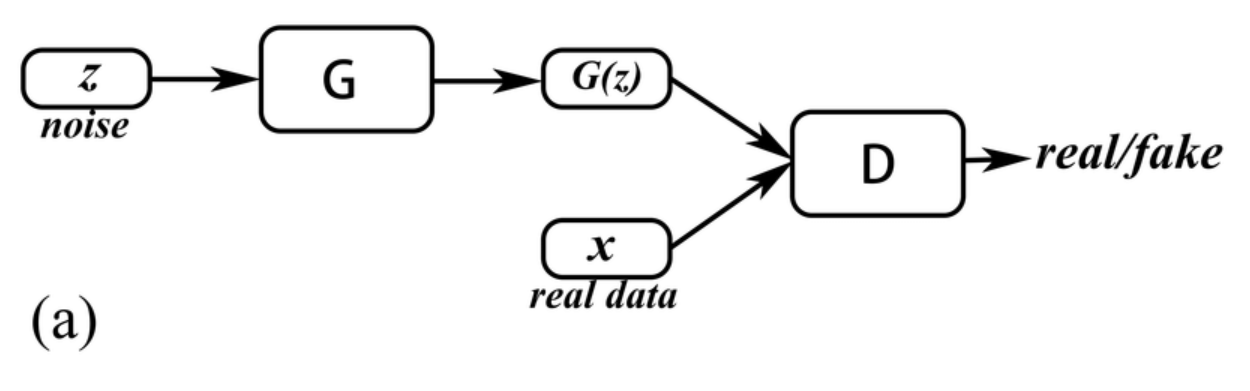

In this section, we will implement a basic Generative Adversarial Network (GAN) to generate fake images of handwritten digits using the MNIST dataset. The main components of this GAN include:

1. **Data Preprocessing**: Loading the MNIST dataset and applying necessary transformations.
2. **Generator**: A neural network that takes random noise as input and generates an image.
3. **Discriminator**: A neural network that takes an image as input and classifies it as real or fake.
4. **Training Loop**: Training the generator and discriminator in alternating steps.
5. **Results**: Visualizing the generated images and logging the training process.

Your task is to follow along with the provided code, understand the underlying concepts, and fill in any missing parts as instructed. Pay close attention to the network architectures, loss functions, and training dynamics to grasp how GANs function.


In [ ]:
# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.main(z)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.main(image).view(-1, 1)

In [ ]:
def save_fake_images(epoch, generator, fixed_z, batch_size, z_dim):
    sample_path = 'gan'
    if not os.path.exists(sample_path):
        os.makedirs(sample_path)

    fake_images = generator(fixed_z).view(batch_size, 1, 64, 64)
    plt.figure(figsize=(16, 4))
    for i in range(8):
        img = fake_images[i].cpu().detach().squeeze().numpy()
        img = (img + 1) / 2
        img = np.clip(img, 0, 1)

        plt.subplot(1, 8, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.show()

In [ ]:
def train_discriminator(discriminator, images, real_labels, fake_image, fake_labels, criterion, optimizer):

    # Hint: Pass real and fake images to discriminator and backporpagate sum of real and fake losses
    # Your code here [10 score]
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs

    outputs = discriminator(fake_image)
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()


def train_generator(discriminator, fake_image, real_labels, criterion, optimizer):
    # Hint: Use discriminator to evaluate fake_image and calculate and backpropagate the generator loss (g_loss)
    # Your code here [10 score]
    generator.zero_grad()
    g_loss = criterion(discriminator(fake_image), real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [ ]:
num_epochs = 20
batch_size = 32
z_dim = 100
criterion = nn.BCELoss()

generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Define optimizer
d_optimizer = torch.optim.Adam(discriminator.parameters(),lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(),lr=0.0002)

# To generate a few images after each epoch
fixed_z = Variable(torch.randn(batch_size, z_dim)).cuda()

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.cuda()
        z = Variable(torch.randn(batch_size, z_dim)).cuda()
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()

        # Train Discriminator
        fake_image = generator(z)
        d_loss = train_discriminator(discriminator, images, real_labels, fake_image, fake_labels, criterion, d_optimizer)

        # Train Generator
        z = Variable(torch.randn(batch_size, z_dim)).cuda()
        fake_image = generator(z)
        g_loss = train_generator(discriminator, fake_image, real_labels, criterion, g_optimizer)

        if i % 10 == 0:
            print(f'\rEpoch {epoch+1}, Step {i+1}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}',end='')

    # Generate and save a few fake images
    save_fake_images(epoch+1, generator, fixed_z, batch_size, z_dim)

<br><br><br><br><br><br><br><br>

# Part 2: Implementation of a Conditional GAN (CGAN)

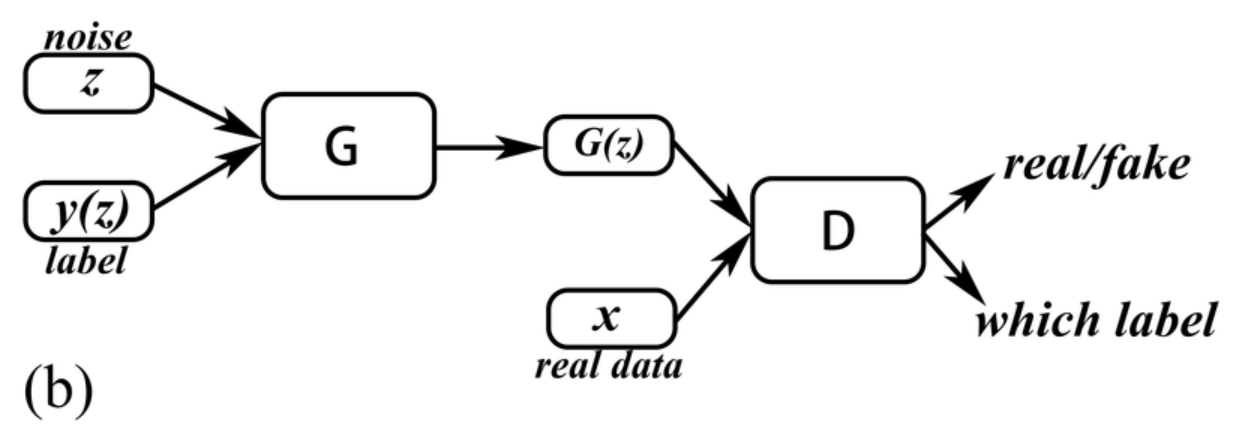

In this section, we will implement a Conditional Generative Adversarial Network (CGAN) to generate fake images of handwritten digits, conditioned on their labels, using the MNIST dataset. This means that we can generate images of specific digits by providing the desired digit label as input to the generator.

The main components of this CGAN include:

1. **Data Preprocessing**: Loading the MNIST dataset with labels and applying necessary transformations.
2. **Generator**: A neural network that takes random noise and a digit label as input and generates an image.
3. **Discriminator**: A neural network that takes an image and a digit label as input and classifies it as real or fake.
4. **Training Loop**: Training the generator and discriminator in alternating steps, taking the digit labels into account.
5. **Results**: Visualizing the generated images conditioned on labels and logging the training process.


In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim=100, label_dim=10):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim)
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            # Hint: Use Linear, BatchNorm1d and proper activation layers
            # Hint: The first layer is given.
            # Your code here [10 score]
            *block(z_dim + label_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(64 * 64))),
            nn.Tanh()

        )


    def forward(self, noise, labels):
        labels = self.label_embedding(labels)
        labels = labels.view(labels.size(0), -1)
        gen_input = torch.cat((noise, labels), 1)  # Concatenate along the feature dimension
        img = self.model(gen_input)
        img = img.view(img.size(0), 1, 64, 64)
        return img

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, label_dim=10):
        super(ConditionalDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            # Hint: Use Linear, BatchNorm1d and proper activation layers
            # Hint: You may need use Dropout layers
            # Your code here [10 score]
            nn.Linear(label_dim + int(np.prod(64 * 64)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()

        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
# Initialize generator and discriminator
generator = ConditionalGenerator().cuda()
discriminator = ConditionalDiscriminator().cuda()

# Loss functions
adversarial_loss = torch.nn.BCELoss()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
def save_fake_labled_images(epoch=0):
    sample_path = 'cgan/'
    if not os.path.exists(sample_path):
        os.makedirs(sample_path)

    sample_labels = torch.arange(10).type(torch.LongTensor).cuda()
    z = torch.randn(10, 100).cuda()
    gen_imgs = generator(z, sample_labels)

    fig, axs = plt.subplots(1, 10, figsize=(18, 2))

    for i in range(10):
        img = gen_imgs[i].cpu().detach().squeeze().numpy()
        img = (img + 1) / 2
        img = np.clip(img, 0, 1)

        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"Label: {i}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(sample_path + f"generated_images_with_labels_{epoch}.png")
    plt.show()

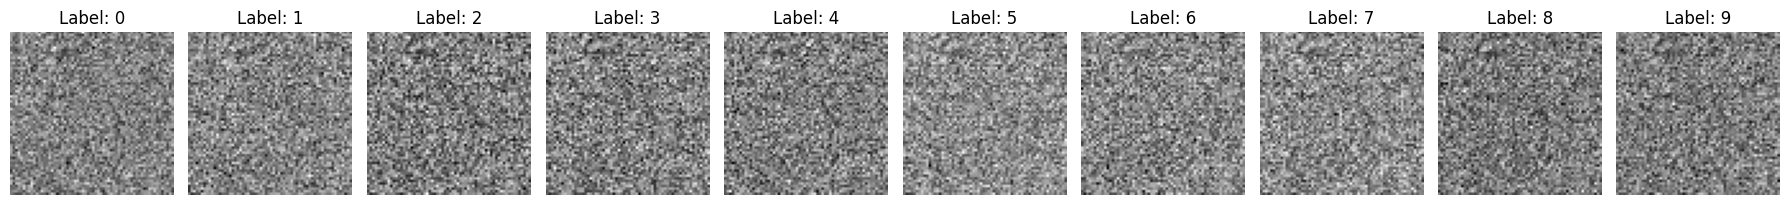

In [ ]:
save_fake_labled_images(epoch=0)

In [ ]:
num_epochs = 20 #change it if you need

# Labels for generated images
sample_labels = torch.randint(0, 10, (32,)).type(torch.LongTensor).cuda()

for epoch in range(200):
    for i, (imgs, labels) in enumerate(data_loader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).cuda()
        fake = torch.zeros(batch_size, 1).cuda()
        imgs = imgs.to("cuda")
        labels = labels.to("cuda")
        # Train Generator
        optimizer_G.zero_grad()

        # Hint: Sample noise and labels. Generate a batch of images and calculate and backpropagate g_loss
        # Your code here [10 score]
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 100))).to("cuda")
        gen_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to("cuda")

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Hint: Pass real and fake images to discriminator and backporpagate sum of real and fake losses
        # Your code here [10 score]
        validity_real = discriminator(imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Save training progress
        if i % 10 == 0:
            print(f'\rEpoch {epoch+1}, Step {i+1}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}', end='')

    save_fake_labled_images(epoch)

**Question:** [10 score]

With learned insights from the notebook, compare Conditional Generative Adversarial Networks (CGANs) and traditional Generative Adversarial Networks (GANs) in terms of architecture, input data, loss functions, and potential applications.


Conditional Generative Adversarial Networks (CGANs) and traditional Generative Adversarial Networks (GANs) share a fundamental architecture, but they differ in how they handle input data and the objectives they aim to achieve. Let's compare them in terms of architecture, input data, loss functions, and potential applications:

### Architecture:

#### GANs (Traditional Generative Adversarial Networks):
- **Generator (G):** Takes random noise as input and generates synthetic data.
- **Discriminator (D):** Receives both real and generated data as input and tries to distinguish between them.
- The training process involves the generator trying to produce realistic data, and the discriminator getting better at distinguishing real from fake.

#### CGANs (Conditional Generative Adversarial Networks):
- **Generator (G):** Takes both random noise and additional conditional information as input to generate synthetic data.
- **Discriminator (D):** Receives both real data and the corresponding conditional information, as well as generated data with the same conditional information.
- The conditional information can be anything relevant to the task, such as class labels in image generation.

### Input Data:

#### GANs:
- GANs typically operate with only random noise as input for the generator.
- The generator learns to generate diverse data samples based solely on the random noise.

#### CGANs:
- CGANs have an additional input layer for conditional information.
- Conditional information could be class labels, specific attributes, or any other relevant data that guides the generation process.

### Loss Functions:

#### GANs:
- GANs use two main loss functions: the generator loss and the discriminator loss.
- The generator aims to minimize the probability that the discriminator correctly classifies generated samples as fake.
- The discriminator aims to correctly classify real and generated samples.

#### CGANs:
- CGANs use a similar adversarial loss for both the generator and discriminator.
- In addition to the adversarial loss, there is a conditional loss. The generator is penalized if the generated samples don't match the desired conditional information.

### Potential Applications:

#### GANs:
- Image generation (e.g., creating realistic faces, artworks).
- Style transfer (changing the style of an image).
- Data augmentation.

#### CGANs:
- Image-to-image translation (e.g., turning satellite images into maps).
- Conditional image generation (e.g., generating specific classes of images).
- Super-resolution with specific features in mind.



